In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask

In [2]:
#import dask to parallelise
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [3]:
ctrl_sst = xr.open_dataset("/g/data/e14/sm2435/PO_model_clim/ctrl_sst.nc", chunks = {"time":12})

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


In [4]:
po_pace_sst = xr.open_dataset("/g/data/e14/sm2435/PO_model_clim/sst.nc", chunks = {"time":12})

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


In [5]:
oc_pace_sst = xr.open_dataset("/g/data/e14/sm2435/PO_model_clim/obs_c_sst.nc", chunks = {"time":12})

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


In [6]:
def regrid_ACCESS(ds):
    #rename coords
    ds = ds.rename({"geolon_t": "longitude", "geolat_t": "latitude"})
    #create the output grid
    ds_out = xe.util.grid_global(1, 1)
    ds_out = ds_out.drop({'lon_b', 'lat_b'})
    #rename grid coords
    ds_out = ds_out.rename({'lon': 'longitude', 'lat': 'latitude'})
    #drop the coords on input ds
    ds_in_1deg = ds.drop({'xt_ocean', 'yt_ocean'})
    #create regridder
    regridder_1deg = xe.Regridder(ds_in_1deg, ds_out, 'bilinear', periodic=True)
    #now regrid
    regridded = regridder_1deg(ds['sst'].chunk({'xt_ocean': -1, 'yt_ocean': -1}))
    regridded = regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
    regridded = regridded.rename({'x': 'longitude', 'y': 'latitude'})
    return regridded

In [ ]:
ctrl = regrid_ACCESS(ctrl_sst)
ctrl = ctrl.compute()

In [ ]:
MC = regrid_ACCESS(po_pace_sst)

In [ ]:
MC = MC.compute()

In [ ]:
OC = regrid_ACCESS(oc_pace_sst)

In [ ]:
OC = OC.compute()

In [ ]:
MC1 = MC.sel(time = slice('0951-01-01','0980-12-31' ))
MC2 = MC.sel(time = slice('0981-01-01','1010-12-31' ))
MC3 = MC.sel(time = slice('1011-01-01','1040-12-31' ))
MC4 = MC.sel(time = slice('1041-01-01','1070-12-31' ))
MC5 = MC.sel(time = slice('1071-01-01','1100-12-31' ))


In [ ]:
#now assign time coord to be the same

In [ ]:
MC2 = MC2.assign_coords(time = MC1.time)
MC3 = MC3.assign_coords(time = MC1.time)
MC4 = MC4.assign_coords(time = MC1.time)
MC5 = MC5.assign_coords(time = MC1.time)

In [ ]:
OC.sel(latitude=slice(-5, 5),longitude=slice(-170, -120))[0].plot()
OC[0].plot(alpha = 0.5)

In [ ]:
#get an index to calcualte the IOB
def ssta(DS):
    clim = DS.groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta
def NINO34(DS):
     return ssta(DS).sel(latitude=slice(-5, 5),longitude=slice(-170, -120)).mean(['latitude', 'longitude'])
     
def IOBM(DS):
    return ssta(DS).sel(latitude=slice(-20, 20),longitude=slice(40, 100)).mean(['latitude', 'longitude'])
def NINO34(DS):
    return (DS).sel(latitude=slice(-5, 5),longitude=slice(-170, -120)).mean(['latitude', 'longitude'])
#calculate the DMI
def dmi(DS):
    WTIO = ssta(DS).sel(latitude=slice(-10, 10),longitude=slice(50, 70)).mean(['latitude', 'longitude'])
    SETIO = ssta(DS).sel(latitude=slice(-10, 0),longitude=slice(90, 110)).mean(['latitude', 'longitude'])
    return  WTIO-SETIO
#redefin Ninoglo index
def Ningaloo2(DS):
    return ssta(DS).sel(latitude=slice(-28, -22),longitude=slice(112, 114)).mean(['latitude', 'longitude'])

In [ ]:
OC_n34 = NINO34(OC)

In [ ]:
OC_n34.plot()

In [ ]:
MC_small = MC.sel(time = slice('0951-01-16','0981-12-16' ))
ctrl_sm = ctrl.sel(time = slice('0951-01-16','0981-12-16' ))

In [ ]:
plt.figure(figsize = (8,4))
Ningaloo2(OC).plot(label = 'obs_clim')
Ningaloo2(MC_small).plot(label = "model_clim")
Ningaloo2(ctrl_sm).plot(label = 'ctrl')
plt.legend()

In [ ]:
ctrl_clim = ctrl.groupby('time.month').mean('time').rename({"month":"time"}).assign_coords({"time": ctrl[:12].time})

In [ ]:
plt.figure(figsize = (8,4))
dmi(OC.sel(time = slice('0951-01-16','0981-12-16' ))).plot(label = "obs_clim")
dmi(MC1).plot(label = "model_clim", color = 'tab:orange', alpha = 0.2)
dmi(MC2).plot(label = "model_clim", color = 'tab:orange', alpha = 0.2)
dmi(MC3).plot(label = "model_clim", color = 'tab:orange', alpha = 0.2)
dmi(MC4).plot(label = "model_clim", color = 'tab:orange', alpha = 0.2)
dmi(MC5).plot(label = "model_clim", color = 'tab:orange', alpha = 0.2)
dmi(ctrl_sm).plot(label = "ACCESS CTRL")
plt.legend()

In [ ]:
oc_dmi = dmi(OC.sel(time = slice('0951-01-16','0981-12-16' )))
mc_dmi = dmi(MC_small)
mc1_dmi = dmi(MC1)
mc2_dmi = dmi(MC2)
mc3_dmi = dmi(MC3)
mc4_dmi = dmi(MC4)
mc5_dmi = dmi(MC5)

ct_dmi = dmi(ctrl_sm)


In [ ]:
NINO34(OC).groupby('time.month').std('time').plot(label = "obs_clim")
NINO34(MC).groupby('time.month').std('time').plot(label = "model_clim")
NINO34(MC1).groupby('time.month').std('time').plot(label = "model_clim", color = 'tab:green', alpha = 0.2)
NINO34(MC2).groupby('time.month').std('time').plot(label = "model_clim", color = 'tab:green', alpha = 0.2)
NINO34(MC3).groupby('time.month').std('time').plot(label = "model_clim", color = 'tab:green', alpha = 0.2)
NINO34(MC4).groupby('time.month').std('time').plot(label = "model_clim", color = 'tab:green', alpha = 0.2)
NINO34(MC5).groupby('time.month').std('time').plot(label = "model_clim", color = 'tab:green', alpha = 0.2)

NINO34(ctrl_sm).groupby('time.month').std('time').plot(label = "ACCESS CTRL")
plt.legend()

In [ ]:
Ningaloo2(OC).groupby('time.month').std('time').plot(label = "obs_clim")
Ningaloo2(MC).groupby('time.month').std('time').plot(label = "model_clim")
Ningaloo2(MC1).groupby('time.month').std('time').plot(label = "model_clim", color = 'tab:green', alpha = 0.2)
Ningaloo2(MC2).groupby('time.month').std('time').plot(label = "model_clim", color = 'tab:green', alpha = 0.2)
Ningaloo2(MC3).groupby('time.month').std('time').plot(label = "model_clim", color = 'tab:green', alpha = 0.2)
Ningaloo2(MC4).groupby('time.month').std('time').plot(label = "model_clim", color = 'tab:green', alpha = 0.2)
Ningaloo2(MC5).groupby('time.month').std('time').plot(label = "model_clim", color = 'tab:green', alpha = 0.2)

Ningaloo2(ctrl_sm).groupby('time.month').std('time').plot(label = "ACCESS CTRL")
plt.legend()

In [ ]:
oc_dmi.groupby('time.month').std('time').plot(label = "obs_clim")
#mc_dmi.groupby('time.month').std('time').plot(label = "model_clim")
mc1_dmi.groupby('time.month').std('time').plot(label = "model_clim", color = 'tab:green', alpha = 0.2)
mc2_dmi.groupby('time.month').std('time').plot(label = "model_clim", color = 'tab:green', alpha = 0.2)
mc3_dmi.groupby('time.month').std('time').plot(label = "model_clim", color = 'tab:green', alpha = 0.2)
mc4_dmi.groupby('time.month').std('time').plot(label = "model_clim", color = 'tab:green', alpha = 0.2)
mc5_dmi.groupby('time.month').std('time').plot(label = "model_clim", color = 'tab:green', alpha = 0.2)

ct_dmi.groupby('time.month').std('time').plot(label = "ACCESS CTRL")
plt.legend()
plt.title("DMI standard deviation by month")

In [22]:
NINO34(MC_small).mean()

<xarray.DataArray ()>
array(26.751842, dtype=float32)

In [23]:
#OBS_clim 
OBS = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/hadisst_clim_1x1.nc")

In [24]:
OBS = OBS.__xarray_dataarray_variable__

In [25]:
ctrl.time[12:]

<xarray.DataArray 'time' (time: 2400)>
array([cftime.DatetimeGregorian(951, 1, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(951, 2, 15, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(951, 3, 16, 12, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.DatetimeGregorian(1150, 10, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1150, 11, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1150, 12, 16, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 0951-01-16 12:00:00 ... 1150-12-16 12:00:00

In [26]:
obs2 = OBS.rename({"month":"time"})
obs2 = obs2.assign_coords({"time": ctrl[:12].time})

In [27]:
obs2

<xarray.DataArray '__xarray_dataarray_variable__' (time: 12, latitude: 180,
                                                   longitude: 360)>
[777600 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time       (time) object 0950-01-16 12:00:00 ... 0950-12-16 12:00:00

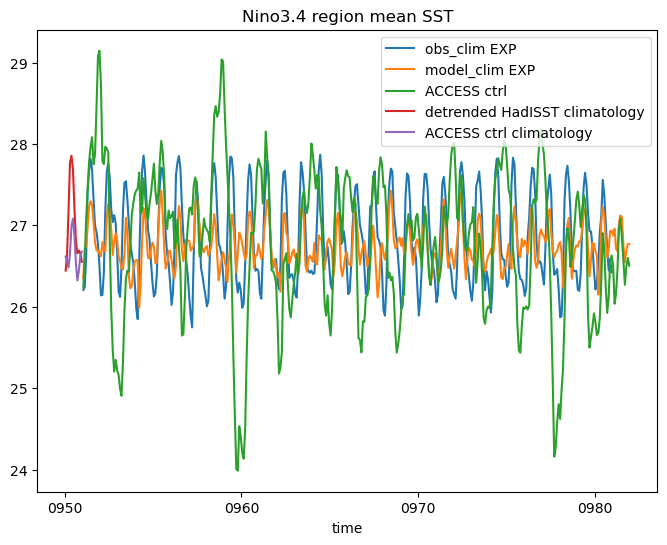

In [37]:
plt.figure(figsize = (8,6))
NINO34(OC).plot(label = "obs_clim EXP")
NINO34(MC_small).plot(label = "model_clim EXP")
NINO34(ctrl_sm).plot(label = "ACCESS ctrl")
NINO34(obs2).plot(label = 'detrended HadISST climatology')
NINO34(ctrl_clim).plot(label = 'ACCESS ctrl climatology')
plt.title("Nino3.4 region mean SST")
plt.legend()

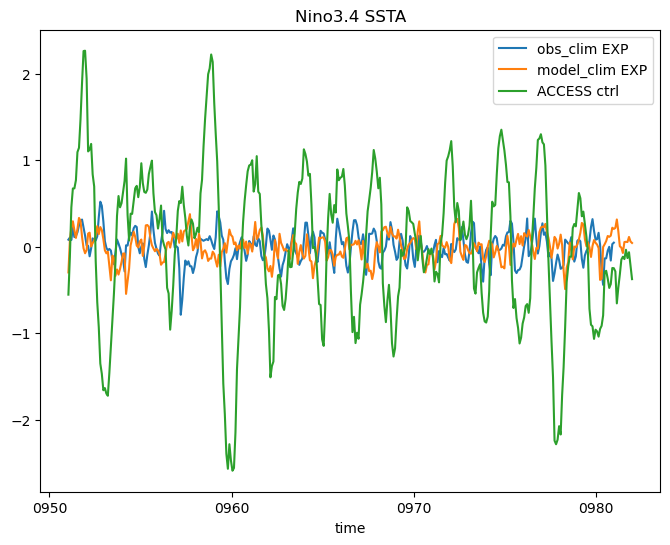

In [43]:
plt.figure(figsize = (8,6))
NINO34(ssta(OC)).plot(label = "obs_clim EXP")
NINO34(ssta(MC_small)).plot(label = "model_clim EXP")
NINO34(ssta(ctrl_sm)).plot(label = "ACCESS ctrl")

plt.title("Nino3.4 SSTA")
plt.legend()

In [29]:
OBS

<xarray.DataArray '__xarray_dataarray_variable__' (month: 12, latitude: 180,
                                                   longitude: 360)>
[777600 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [44]:
OC_clim = OC.groupby('time.month').mean('time')

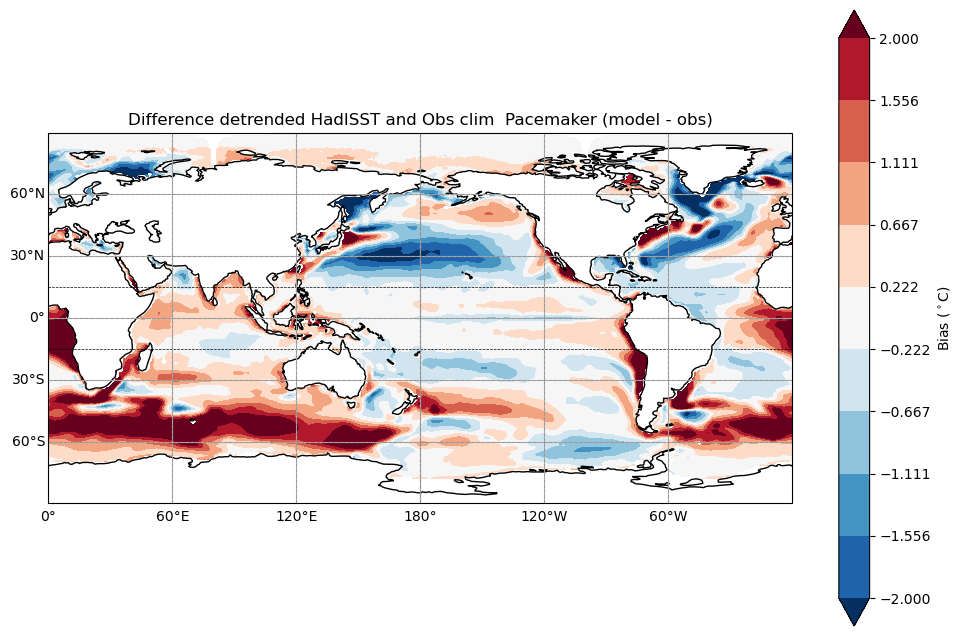

In [45]:
bias = (OC_clim - OBS).mean('month')
plt.figure(figsize = (12,8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
bias.plot.contourf(ax=ax, vmin = -2, vmax = 2, cmap = "RdBu_r", levels = 10, extend = 'both',
       transform=ccrs.PlateCarree(), cbar_kwargs=dict(label='Bias ($^\\circ$C)'))
ax.set_title('Difference detrended HadISST and Obs clim  Pacemaker (model - obs)')
ax.coastlines(color = 'k')
ax.gridlines()
#ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.axhline(15, c = 'k', lw = 0.5, linestyle = '--')
ax.axhline(-15, c = 'k', lw = 0.5, linestyle = '--')


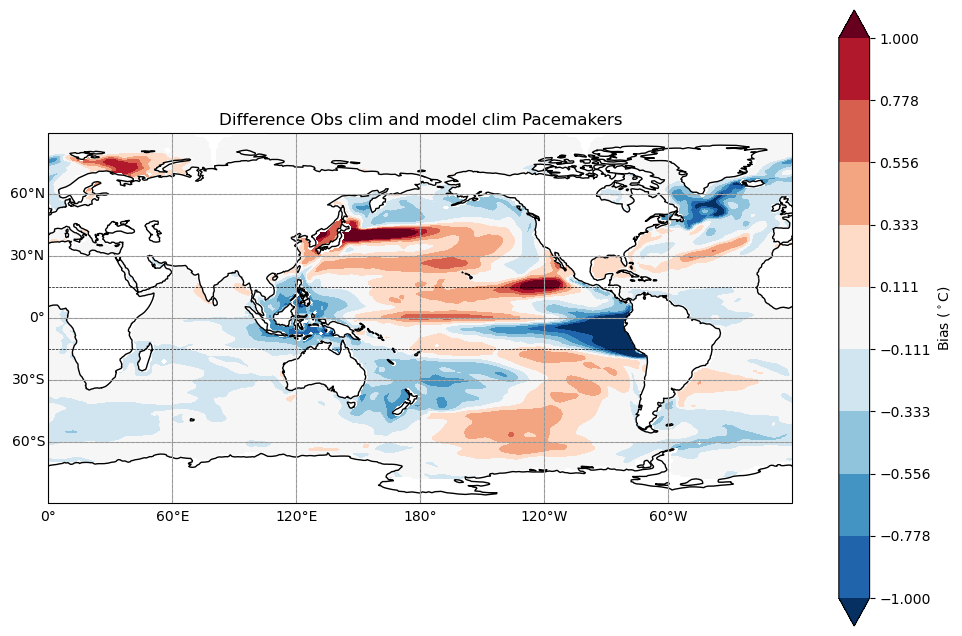

In [46]:
bias = (OC_clim - MC.groupby('time.month').mean('time')).mean('month')
plt.figure(figsize = (12,8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
bias.plot.contourf(ax=ax, vmin = -1, vmax = 1, cmap = "RdBu_r", levels = 10, extend = 'both',
       transform=ccrs.PlateCarree(), cbar_kwargs=dict(label='Bias ($^\\circ$C)'))
ax.set_title('Difference Obs clim and model clim Pacemakers')
ax.coastlines(color = 'k')
ax.gridlines()
#ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.axhline(15, c = 'k', lw = 0.5, linestyle = '--')
ax.axhline(-15, c = 'k', lw = 0.5, linestyle = '--')


In [33]:
OC.dims[0]

'time'

In [47]:
#now write a fucntion to output bias and to optioanlly plot
def sst_bias(model, obs, freq=None, plot=None, temp_scale = 2):
    """
    Lorem ipsum dolor sit amet, consetetur sadipscing elitr,
    sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam
    
    Parameters
    ----------
    model : argument of type int
        DataArray of model run 
    obs : argument of type int
        Lorem ipsum dolor sit amet
    freq : {‘monthly’, ‘annual’}, optional
        if None default to 'monthly'
    plot : True or False
        if true, plot is made, if false then no
    temp_scale : 2 (optional)
        set to 2 automatically, sets vmin vmax

    """
    #check frequency of sampling, defaukt to monthly if not specified
    if freq == None:
        freq = 'monthly'
    if plot == None:
        plot = False
    #check what the obs file is time or month already
    if obs.dims[0] == "time":
        obs_mon = obs.groupby('time.month').mean('time')
        obs_mn = obs.mean('time')
    else:
        obs_mon = obs 
        obs_mn = obs.mean('month')
    
    
    #calculate the bias
    if freq == "monthly":
        bias = (model.groupby('time.month').mean('time') - obs_mon)
        if plot == True:
            fg = bias.plot.contourf(col='month', col_wrap = 4,  transform=ccrs.PlateCarree(),
                                 subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180)}, 
                                  figsize=(20,8), facecolor = 'white', vmin = -1*temp_scale, vmax = temp_scale, levels =10, extend = 'both',  cmap = 'RdBu_r',
                                    cbar_kwargs=dict(label='Bias ($^\\circ$C)'))
            for i, ax in enumerate(fg.axes.flat):
                ax.coastlines()
                #ax.set_facecolor('grey')
                gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
                if i in [0,1,2,3,4,5,6,7]:
                    gl.bottom_labels = False
                if i in [1,2,3,5,6,7,9,10,11]:
                    gl.left_labels = False
                gl.top_labels = False
                gl.right_labels = False               
            #now add the month labels\n",
            titles =['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul',
                     'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            for ax,title in zip(fg.axes.flatten(),titles):
                ax.set_title(title )
            return
        elif plot == False:
            return bias
    elif freq == "annual":
        bias = (model.mean('time') - obs_mn)
        if plot == True:
            plt.figure(figsize = (12,8))
            ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
            bias.plot.contourf(ax=ax, vmin = -1*temp_scale, vmax = temp_scale, cmap = "RdBu_r", levels = 10, extend = 'both',
                   transform=ccrs.PlateCarree(), cbar_kwargs=dict(label='Bias ($^\\circ$C)'))
            ax.set_title('Annual mean SST bias')
            ax.coastlines(color = 'k')
            ax.gridlines()
            #ax.set_facecolor('grey')
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False
            return 
        elif plot == False:
            return bias

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'facecolor'
  result = super().contourf(*args, **kwargs)
/local/e14/sm2435/tmp/ipykernel_3831212/2050293557.py:43: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for i, ax in enumerate(fg.axes.flat):
/local/e14/sm2435/tmp/ipykernel_3831212/2050293557.py:57: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax,title in zip(fg.axes.flatten(),titles):


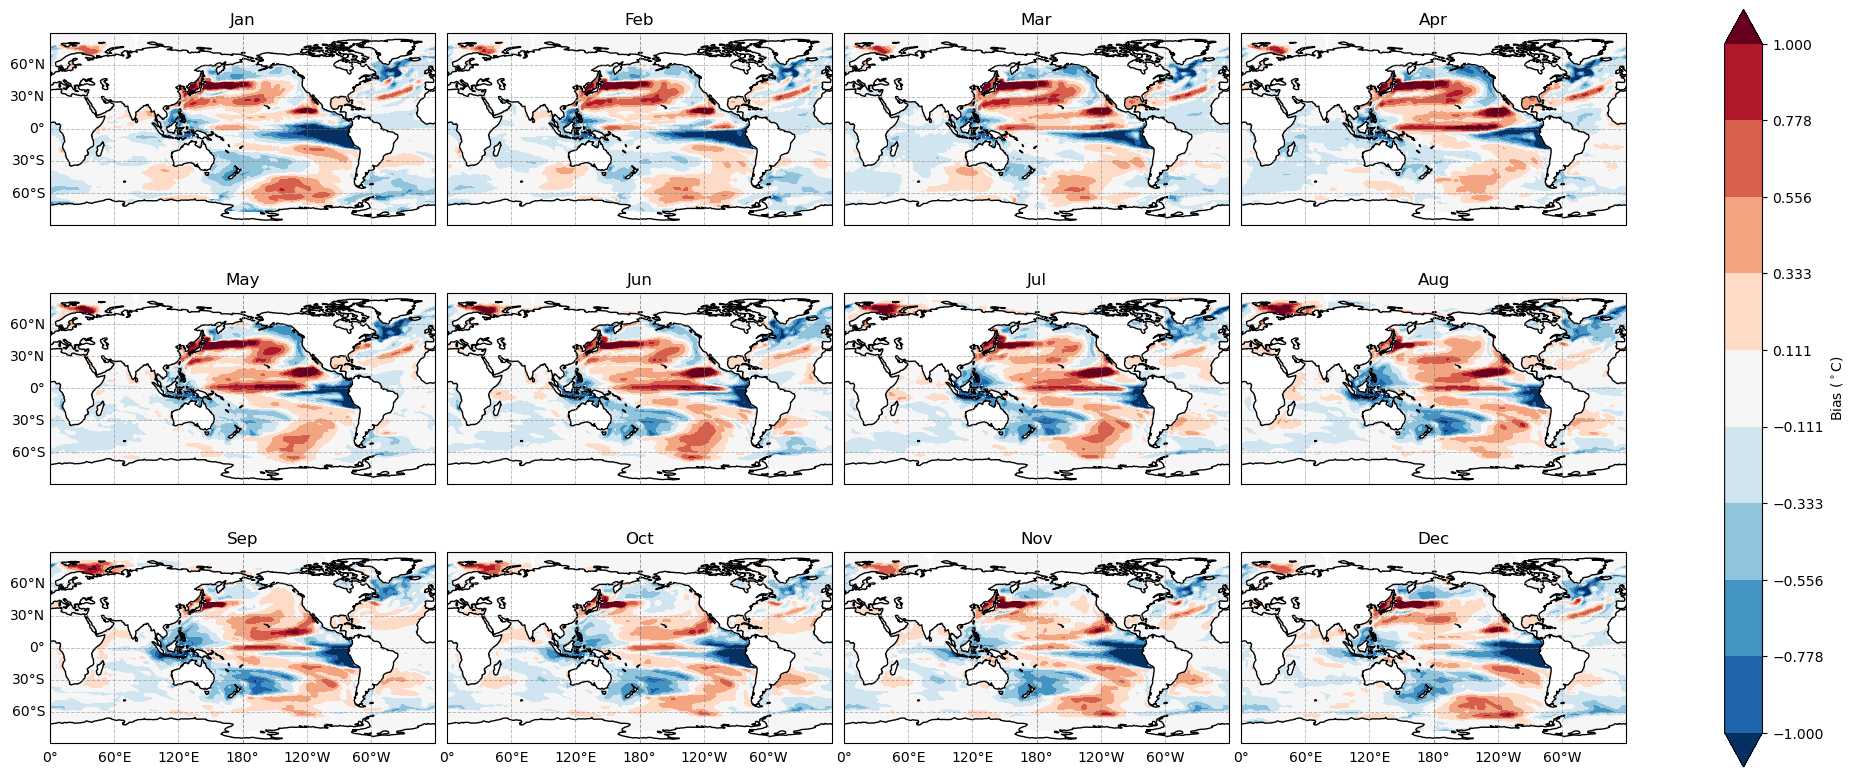

In [48]:
sst_bias(OC, MC,  "monthly", plot=True, temp_scale=1)


Text(0.5, 1.0, 'CTRL - Detrended OBS')

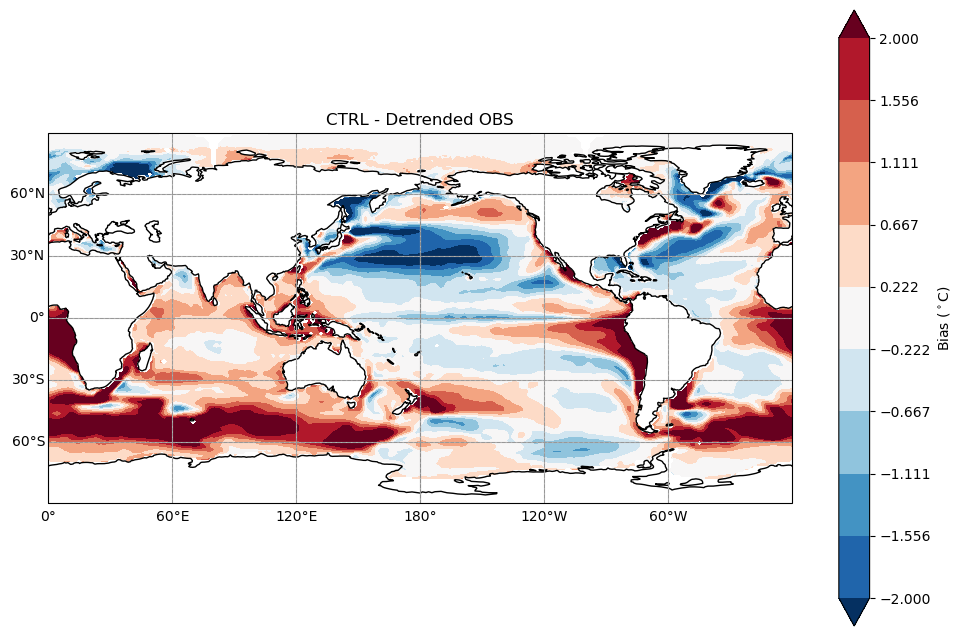

In [40]:
sst_bias(ctrl,OBS,  "annual", plot=True, temp_scale=2)
plt.title("CTRL - Detrended OBS")

Text(0.5, 1.0, 'Obs_clim - Model_clim EXP')

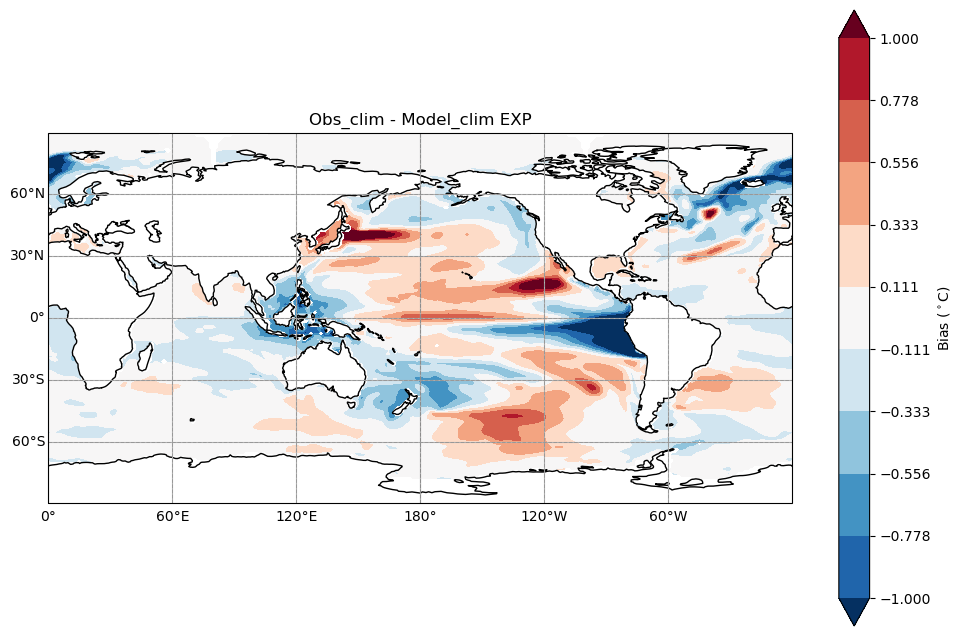

In [36]:
sst_bias(OC, MC,  "annual", plot=True, temp_scale=1)
plt.title("Obs_clim - Model_clim EXP")

Text(0.5, 1.0, 'Model_clim - detrend_HadISST')

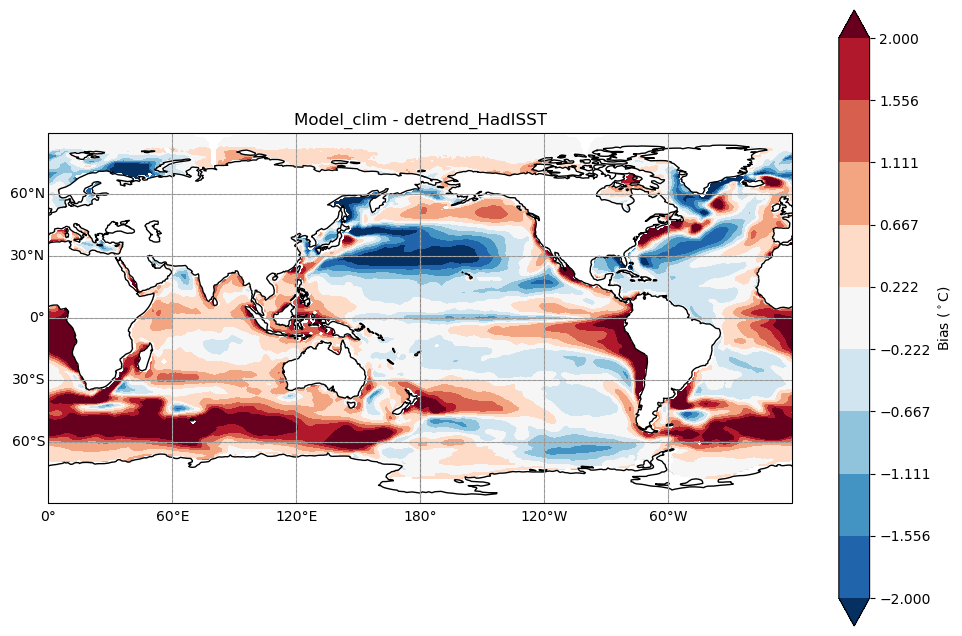

In [37]:
sst_bias(MC, OBS,  "annual", plot=True, temp_scale=2)
plt.title("Model_clim - detrend_HadISST")

Text(0.5, 1.0, 'Obs_clim - detrend_HadISST')

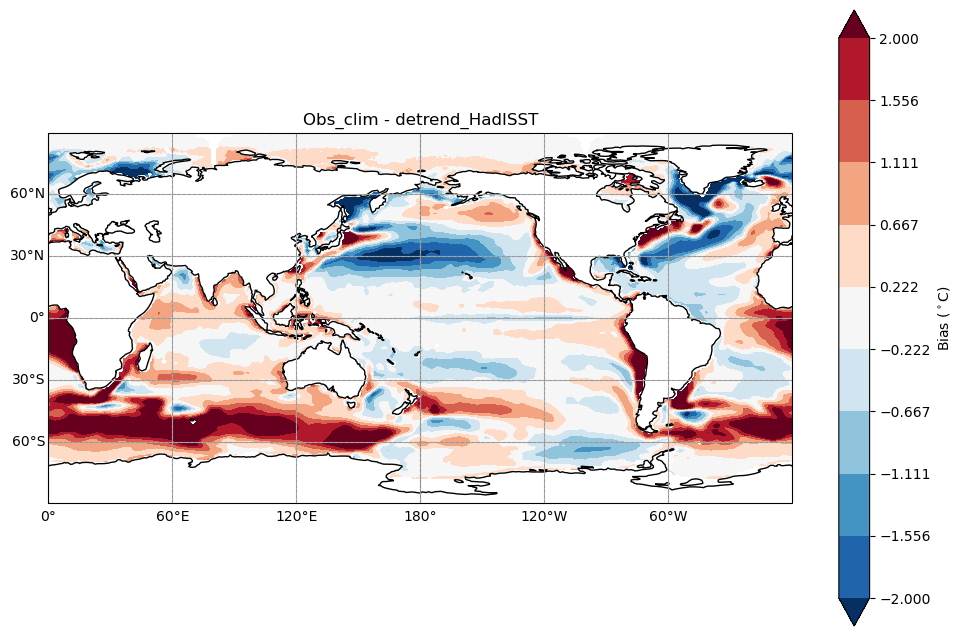

In [49]:
sst_bias(OC, OBS,  "annual", plot=True, temp_scale=2)
plt.title("Obs_clim - detrend_HadISST")

Text(0.5, 1.0, 'Obs_clim - detrend_HadISST')

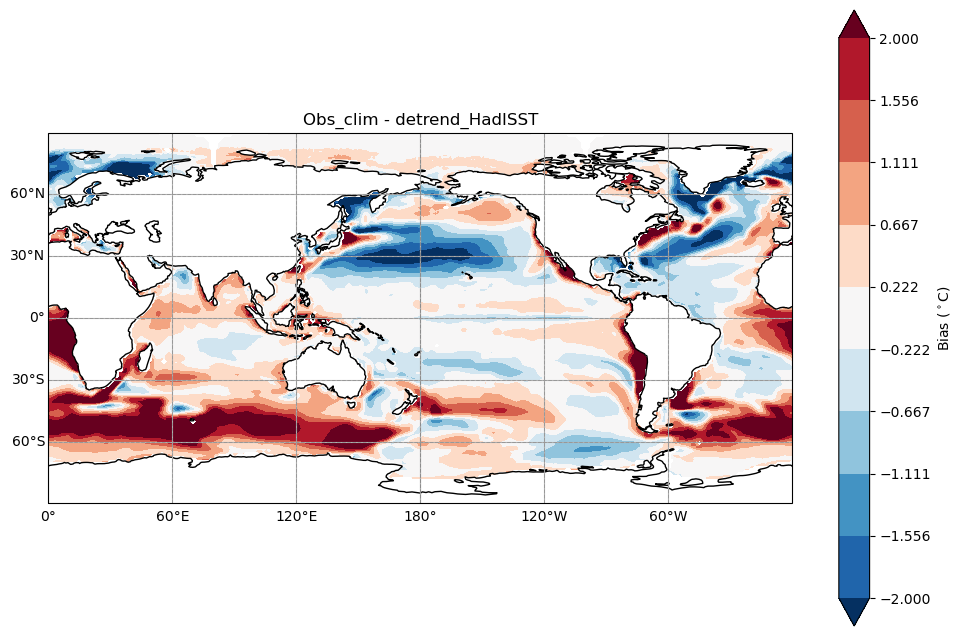

In [38]:
sst_bias(OC, OBS,  "annual", plot=True, temp_scale=2)
plt.title("Obs_clim - detrend_HadISST")

Text(0.5, 1.0, 'Obs_clim - ctrl EXP')

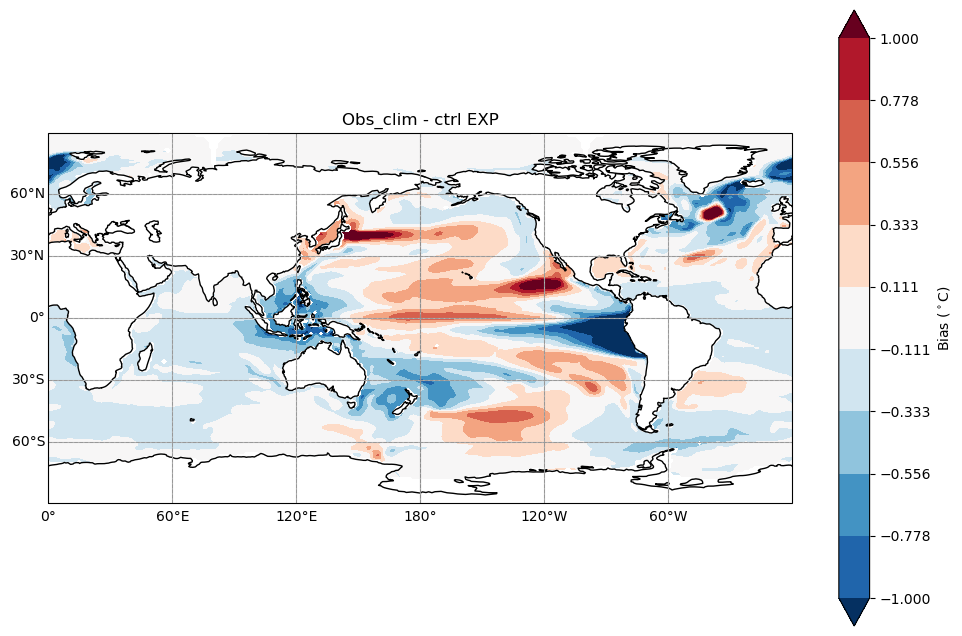

In [39]:
sst_bias(OC, ctrl,  "annual", plot=True, temp_scale=1)
plt.title("Obs_clim - ctrl EXP")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'facecolor'
  result = super().contourf(*args, **kwargs)
/local/e14/sm2435/tmp/ipykernel_2146973/2050293557.py:43: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for i, ax in enumerate(fg.axes.flat):
/local/e14/sm2435/tmp/ipykernel_2146973/2050293557.py:57: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax,title in zip(fg.axes.flatten(),titles):


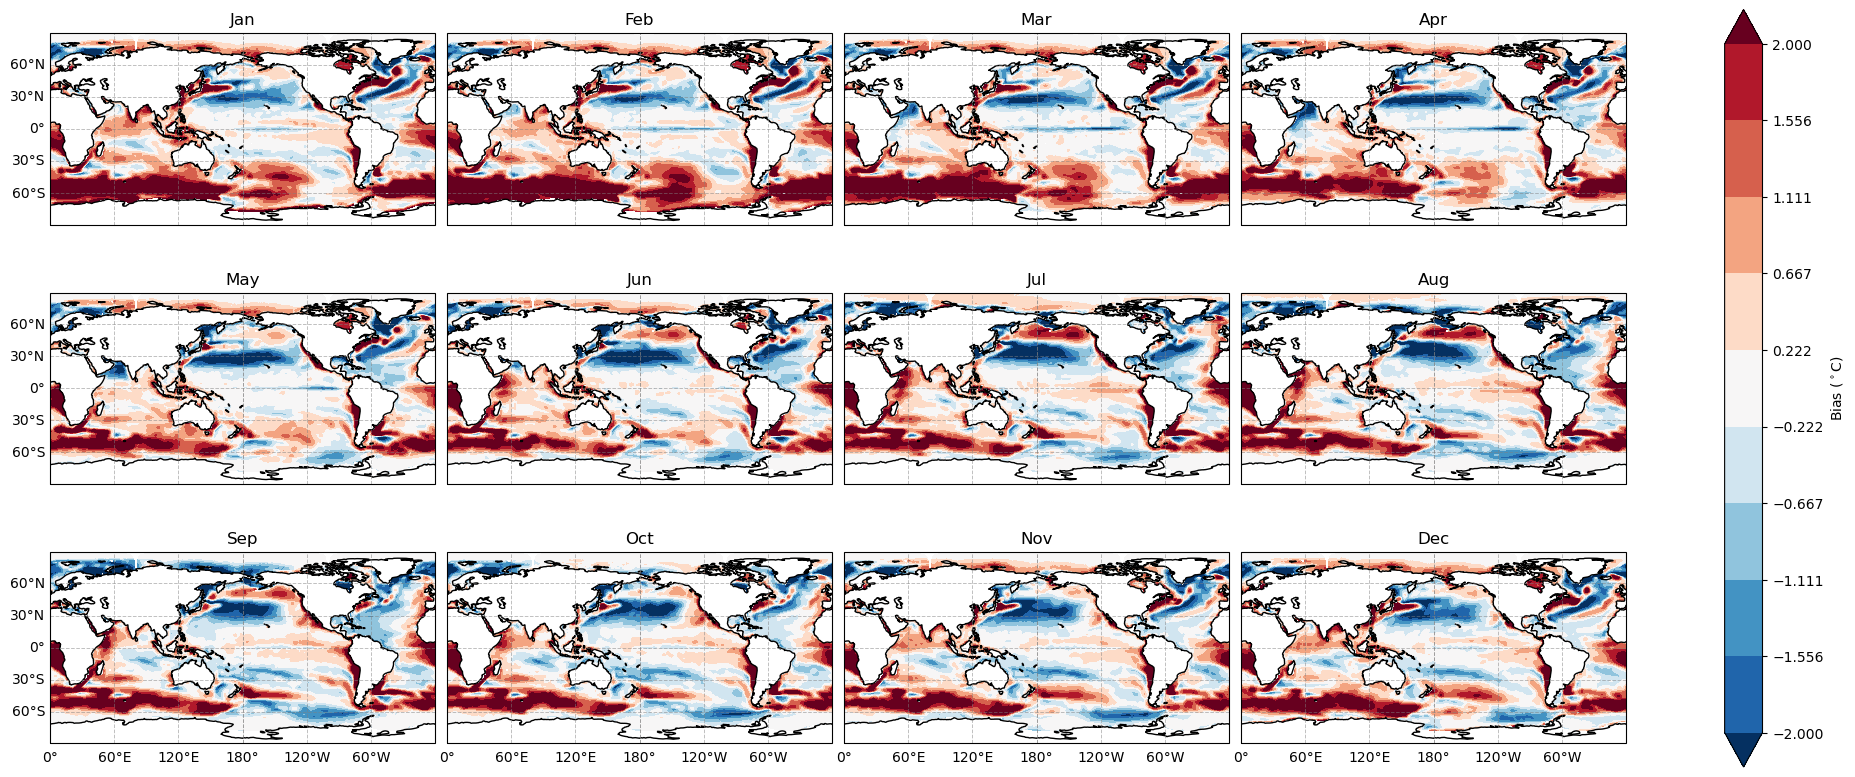

In [40]:
sst_bias(OC, OBS,  "monthly", plot=True, temp_scale=2)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'facecolor'
  result = super().contourf(*args, **kwargs)
/local/e14/sm2435/tmp/ipykernel_2146973/2050293557.py:43: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for i, ax in enumerate(fg.axes.flat):
/local/e14/sm2435/tmp/ipykernel_2146973/2050293557.py:57: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax,title in zip(fg.axes.flatten(),titles):


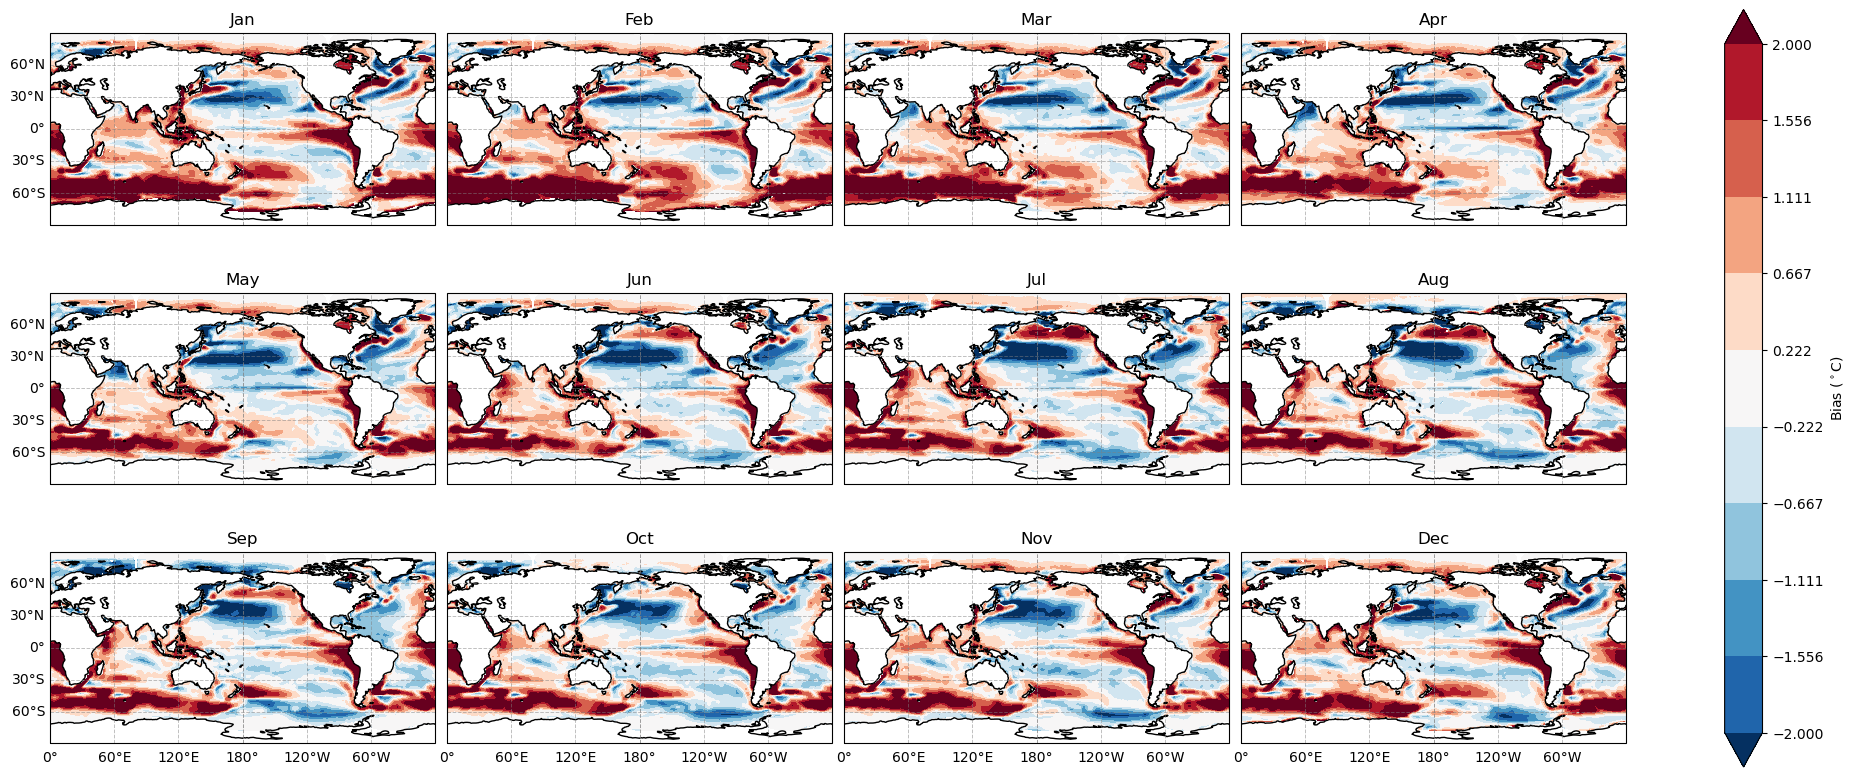

In [41]:
sst_bias(MC, OBS,  "monthly", plot=True, temp_scale=2)


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'facecolor'
  result = super().contourf(*args, **kwargs)
/local/e14/sm2435/tmp/ipykernel_2113052/2050293557.py:43: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for i, ax in enumerate(fg.axes.flat):
/local/e14/sm2435/tmp/ipykernel_2113052/2050293557.py:57: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax,title in zip(fg.axes.flatten(),titles):


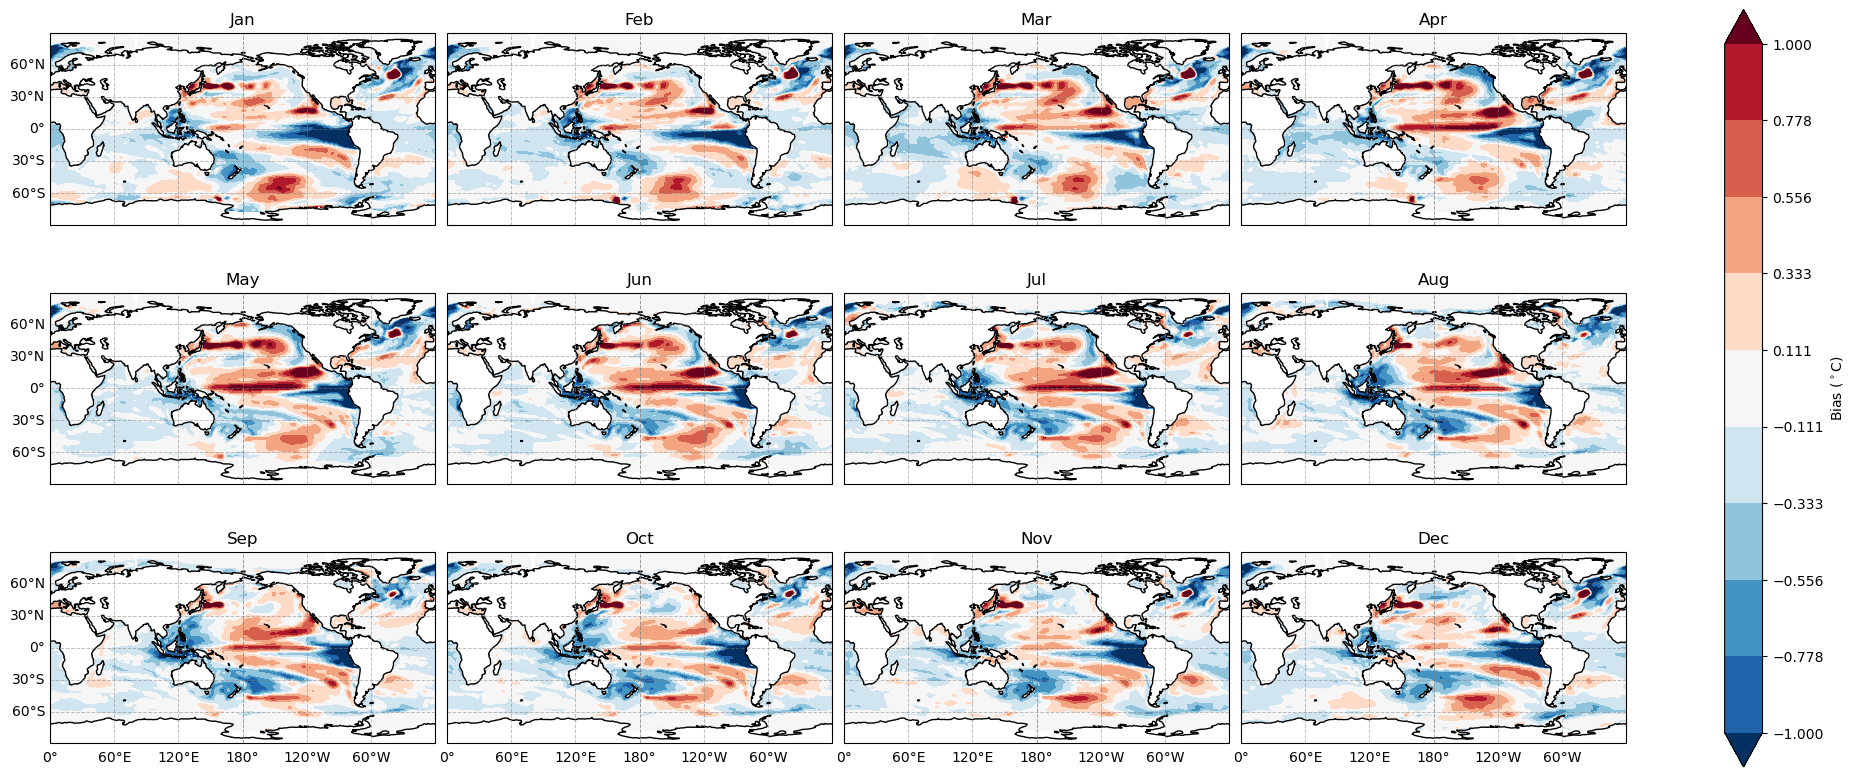

In [42]:
sst_bias(OC, ctrl,  "monthly", plot=True, temp_scale=1)


In [43]:
#load in zoes climatology
model_clim = xr.open_dataset("/g/data/w97/zg0866/pacemaker/global_sst_restoring_cm000_climatology_0951-1150.nc", decode_times=False).temp

In [44]:
model_clim = model_clim.rename({"GRID_X_T":"lon", "GRID_Y_T":"lat", "TIME":"month"})
model_clim = model_clim.assign_coords({"month":OBS.month})#.drop( "DEPTH1_1")


In [45]:
model_clim = model_clim[:,0].drop( "DEPTH1_1")

In [46]:
model_clim

<xarray.DataArray 'temp' (month: 12, lat: 300, lon: 360)>
[1296000 values with dtype=float32]
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float64 -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
  * lon      (lon) float64 -279.5 -278.5 -277.5 -276.5 ... 76.5 77.5 78.5 79.5
Attributes:
    long_name:    Climatology SST restoring
    units:        degrees K
    valid_range:  [-10. 500.]

In [47]:
RG = xe.Regridder(model_clim, OC, "bilinear")

In [48]:
mod_clim = RG(model_clim)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'facecolor'
  result = super().contourf(*args, **kwargs)
/local/e14/sm2435/tmp/ipykernel_2113052/2050293557.py:43: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for i, ax in enumerate(fg.axes.flat):
/local/e14/sm2435/tmp/ipykernel_2113052/2050293557.py:57: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax,title in zip(fg.axes.flatten(),titles):


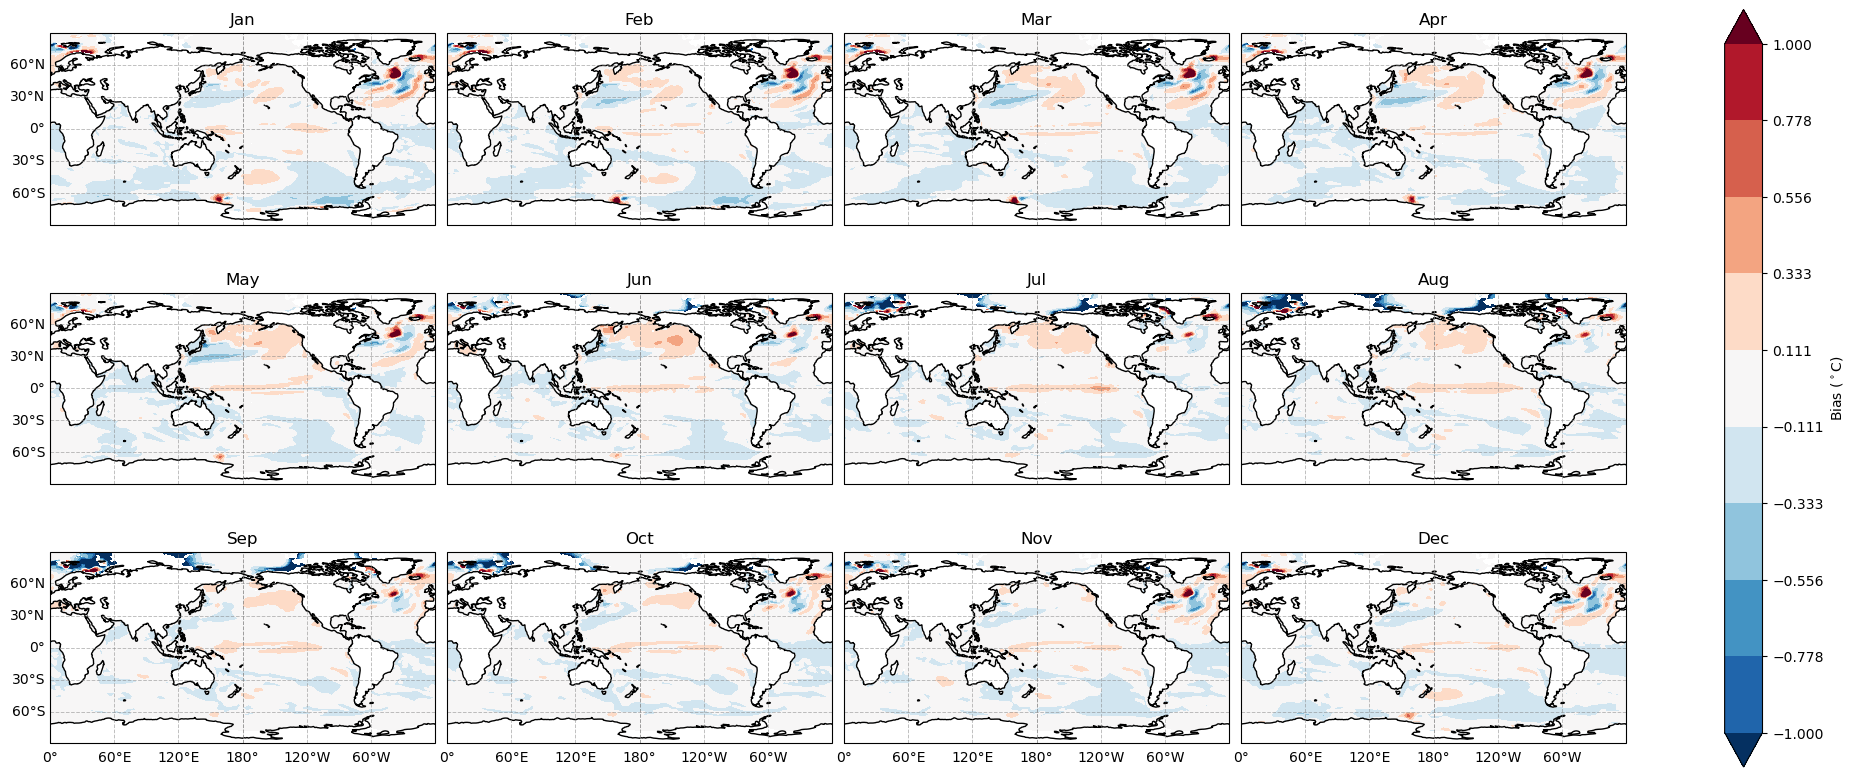

In [49]:
sst_bias(MC, mod_clim,  "monthly", plot=True, temp_scale=1)

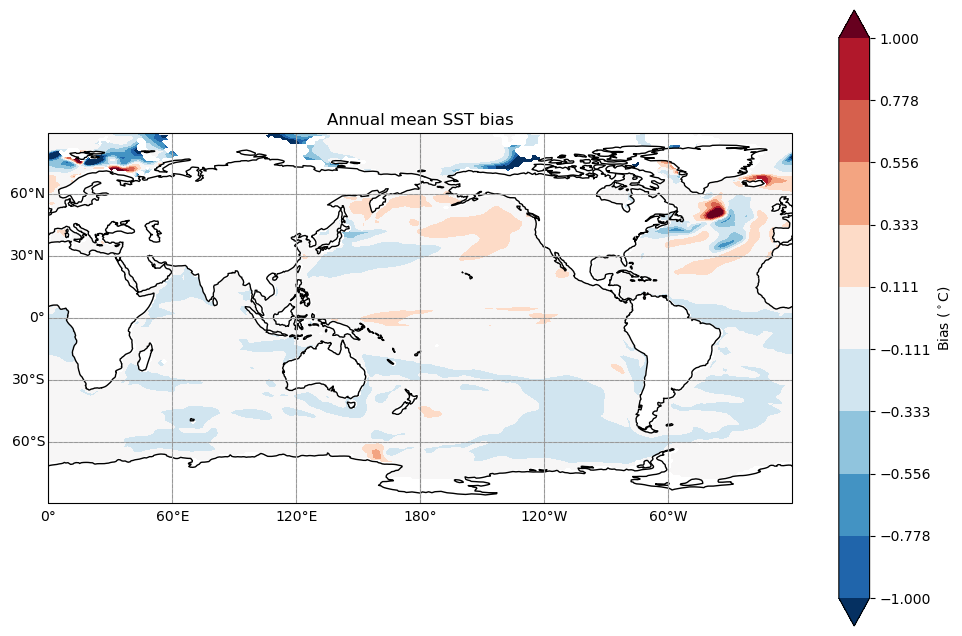

In [50]:
sst_bias(MC, mod_clim,  "annual", plot=True, temp_scale=1)

In [52]:
def linear_trend(x, y):
    pf = np.polyfit(x, y, 1)
    return xr.DataArray(pf[0])

In [53]:
def regress(var1, var2):
    slope = xr.apply_ufunc(linear_trend,
                        var1, var2,
                        vectorize=True,
                        dask = 'parallelized',
                        input_core_dims=[['time'], ['time']],# reduce along 'model'
                        )
    return slope

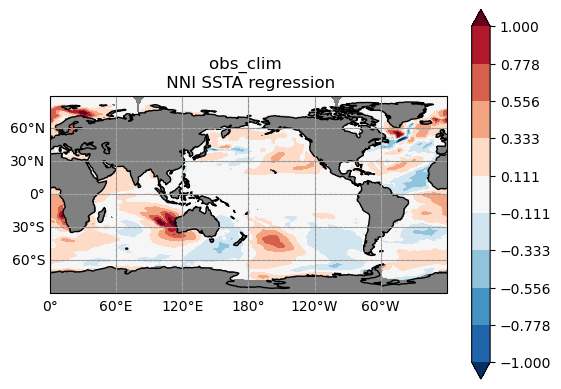

In [54]:
slope = regress(Ningaloo2(OC), ssta(OC))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

slope.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1, vmax = 1, levels = 10, extend = 'both',  cmap = "RdBu_r")
ax.set_title('obs_clim \n NNI SSTA regression')
ax.coastlines(color = 'k')
ax.gridlines()
ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
#ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())

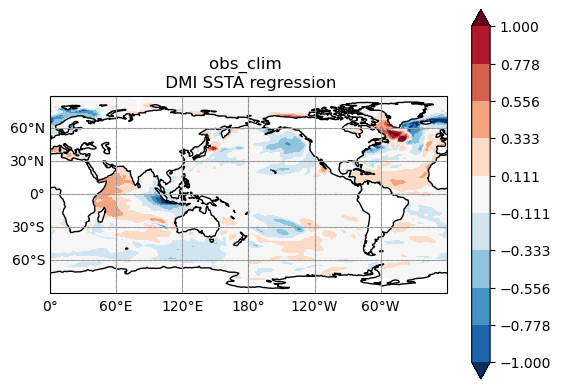

In [57]:
slope = regress(dmi(OC), ssta(OC))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

slope.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1, vmax = 1, levels = 10, extend = 'both',  cmap = "RdBu_r")
ax.set_title('obs_clim \n DMI SSTA regression')
ax.coastlines(color = 'k')
ax.gridlines()
#ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
#ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())

In [55]:
slope = regress(dmi(OBS), ssta(OBS))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

slope.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1, vmax = 1, levels = 10, extend = 'both',  cmap = "RdBu_r")
ax.set_title('obs_clim \n DMI SSTA regression')
ax.coastlines(color = 'k')
ax.gridlines()
#ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
#ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())

KeyError: 'time'

<xarray.DataArray '__xarray_dataarray_variable__' (month: 12, latitude: 180,
                                                   longitude: 360)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-1.8     , -1.8     , ..., -1.8     , -1.8     ],
        [-1.801417, -1.8     , ..., -1.801449, -1.801425]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       ...,

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-1.8     , -1.8     , ..., -1.8     , -1.8     ],
        [-1.801417, -1.8     , ..., -1.801449, -1.801425]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-1.8     , -1.8     , ..., -1.8     , -1.8     ],
        [-1.801417, -1.8     , ..., -1.801449, -1.801425]]])
Coordinates:
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [58]:
test = xr.open_mfdataset("/g/data/e14/sm2435/Pacemaker/cw323a.pd0957jan.nc")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/xarray/core/indexing.py:556: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


In [74]:
test.fld_s30i201[:,-1]

<xarray.DataArray 'fld_s30i201' (time: 31, lat_v: 145, lon_u: 192)>
dask.array<getitem, shape=(31, 145, 192), dtype=float32, chunksize=(31, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0957-01-01 12:00:00 ... 0957-01-31 12:00:00
  * lon_u     (lon_u) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height    float64 ...
  * lat_v     (lat_v) float64 -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
    height_0  float64 ...
    pressure  float64 1e+03
Attributes:
    standard_name:    eastward_wind
    long_name:        U COMPNT OF WIND ON P LEV/UV GRID
    units:            m s-1
    um_stash_source:  m01s30i201
    cell_methods:     time: mean
    grid_mapping:     latitude_longitude

In [20]:
import os

In [25]:
file = f"/scratch/e14/sm2435/archive/cw323/history/atm/cw323a.pm09{i}*.nc"
print(file)

/scratch/e14/sm2435/archive/cw323/history/atm/cw323a.pm0950*.nc


In [56]:
U = xr.open_mfdataset("/g/data/e14/sm2435/Pacemaker/wind/U_09*.nc")
V = xr.open_mfdataset("/g/data/e14/sm2435/Pacemaker/wind/V_09*.nc")#, chunks = {"time":12})


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/xarray/core/indexing.py:556: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_

In [57]:
U = U.fld_s30i201
V = V.fld_s30i202

In [ ]:
U[0].plot()

In [ ]:
V[0].plot()